<br/>
# *Multilevel Modeling*
***

In [25]:
%matplotlib inline

# import pystan
import pymc
import numpy as np
import pandas as pd
from sklearn import preprocessing

import pymc3 as pm
import theano
import theano.tensor as T

In [2]:
%load_ext rpy2.ipython

In [3]:
def make_dataframe(n, s):
    df = pd.DataFrame({
        'success': [0] * (n * 4),
        'country': ['Canada'] * (2 * n) + ['China'] * (2 * n),
        'treated': [0] * n + [1] * n + [0] * n + [1] * n
    })
    
    for i, successes in zip([n, n*2, n*3, n*4], s):
        df.loc[i - n:i - n + successes - 1, 'success'] = 1
    
    return df

# n, ss = 200, [60, 100, 110, 120]
n, ss = 100, [30, 50, 55, 60]

df = make_dataframe(n, ss)

In [4]:
df.head()

,country,success,treated
0,Canada,1,0
1,Canada,1,0
2,Canada,1,0
3,Canada,1,0
4,Canada,1,0


In [5]:
df.groupby(['country', 'treated']).mean()

success
country treated         
Canada  0           0.30
        1           0.50
China   0           0.55
        1           0.60

<br/>

## R Implementations

***

In [9]:
%%R

library(lme4)
library(arm)
library(rstanarm)

In [10]:
%Rpush df

In [11]:
%%R


mod = lmer(success ~ treated + (1 + treated | country), df)

In [12]:
%%R

print(coef(mod)$country[1, 1])
print(coef(mod)$country[1, 1] + coef(mod)$country[1, 2])
print(coef(mod)$country[2, 1])
print(coef(mod)$country[2, 1] + coef(mod)$country[2, 2])

[1] 0.3082298
[1] 0.5032919
[1] 0.5417702
[1] 0.5967081


In [13]:
%%R

mod = glmer(success ~ treated + (1 + treated | country), df, family="binomial")

In [14]:
%%R

inv = function(x) {
    return(exp(x)/(1 + exp(x)))
}

print(inv(coef(mod)$country[1, 1]))
print(inv(coef(mod)$country[1, 1] + coef(mod)$country[1, 2]))
print(inv(coef(mod)$country[2, 1]))
print(inv(coef(mod)$country[2, 1] + coef(mod)$country[2, 2]))

[1] 0.3160388
[1] 0.5071457
[1] 0.5336295
[1] 0.5933197


In [15]:
%%R

mod = stan_glmer(success ~ 1 + treated + (1 + treated | country), df, family="binomial")


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1, Iteration: 2000 / 2000 [100%]  (Sampling)
 Elapsed Time: 19.4504 seconds (Warm-up)
               22.6203 seconds (Sampling)
               42.0706 seconds (Total)


SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 2, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 2, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 2, Iteration:  600 / 2000 [ 

In [16]:
%%R

inv = function(x) {
    return(exp(x)/(1 + exp(x)))
}

print(inv(coef(mod)$country[1, 1]))
print(inv(coef(mod)$country[1, 1] + coef(mod)$country[1, 2]))
print(inv(coef(mod)$country[2, 1]))
print(inv(coef(mod)$country[2, 1] + coef(mod)$country[2, 2]))

[1] 0.3331467
[1] 0.4867165
[1] 0.5149271
[1] 0.6131024


<br/>

## PyMC 3 Implementation
***

In [17]:
le = preprocessing.LabelEncoder()
country_idx = le.fit_transform(df['country'])
n_countries = len(set(country_idx))

In [18]:
with pm.Model() as multilevel_model:
    
    # Hyperiors for intercept (Comment 1)
    mu_a = pm.StudentT('mu_a', nu=3, mu=0., sd=1.0)
    sigma_a = pm.HalfNormal('sigma_a', sd=1.0)
    
    # Hyperpriors for slope
    mu_b = pm.StudentT('mu_b', nu=3, mu=0., sd=1.0)
    sigma_b = pm.HalfNormal('sigma_b', sd=1.0)

    # Model the intercept (Comment 2)
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_countries)

    # Model the slope
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_countries)
        
    # Make things grok-able (Comment 3)
    a_inv = pm.Deterministic('a_inv', T.exp(a)/(1 + T.exp(a)))
    fin = pm.Deterministic('fin', T.exp(a + b)/(1 + T.exp(a + b)))

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    # Calculate predictions given values for intercept and slope (Comment 4)
    yhat = pm.invlogit(a[country_idx] + b[country_idx] * df.treated.values)

    # Make predictions fit reality
    y = pm.Binomial('y', n=np.ones(df.shape[0]), p=yhat, observed=df.success.values)

Applied log-transform to sigma_a and added transformed sigma_a_log_ to model.
Applied log-transform to sigma_b and added transformed sigma_b_log_ to model.
Applied log-transform to eps and added transformed eps_log_ to model.


In [19]:
with multilevel_model:
    mm_trace = pm.sample(2000)

Assigned NUTS to mu_a
Assigned NUTS to sigma_a_log_
Assigned NUTS to mu_b
Assigned NUTS to sigma_b_log_
Assigned NUTS to a
Assigned NUTS to b
Assigned NUTS to eps_log_
 [-----------------100%-----------------] 2000 of 2000 complete in 11.5 sec

In [20]:
pm.summary(mm_trace, varnames=['a_inv', 'fin'])


a_inv:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.327            0.048            0.002            [0.234, 0.415]
  0.529            0.048            0.002            [0.432, 0.615]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.237          0.293          0.326          0.360          0.421
  0.435          0.496          0.529          0.561          0.623


fin:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.488            0.051            0.001            [0.385, 0.582]
  0.608            0.048            0.001            [0.518, 0.701]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|=======

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x143d4a410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x144b7d1d0>]], dtype=object)

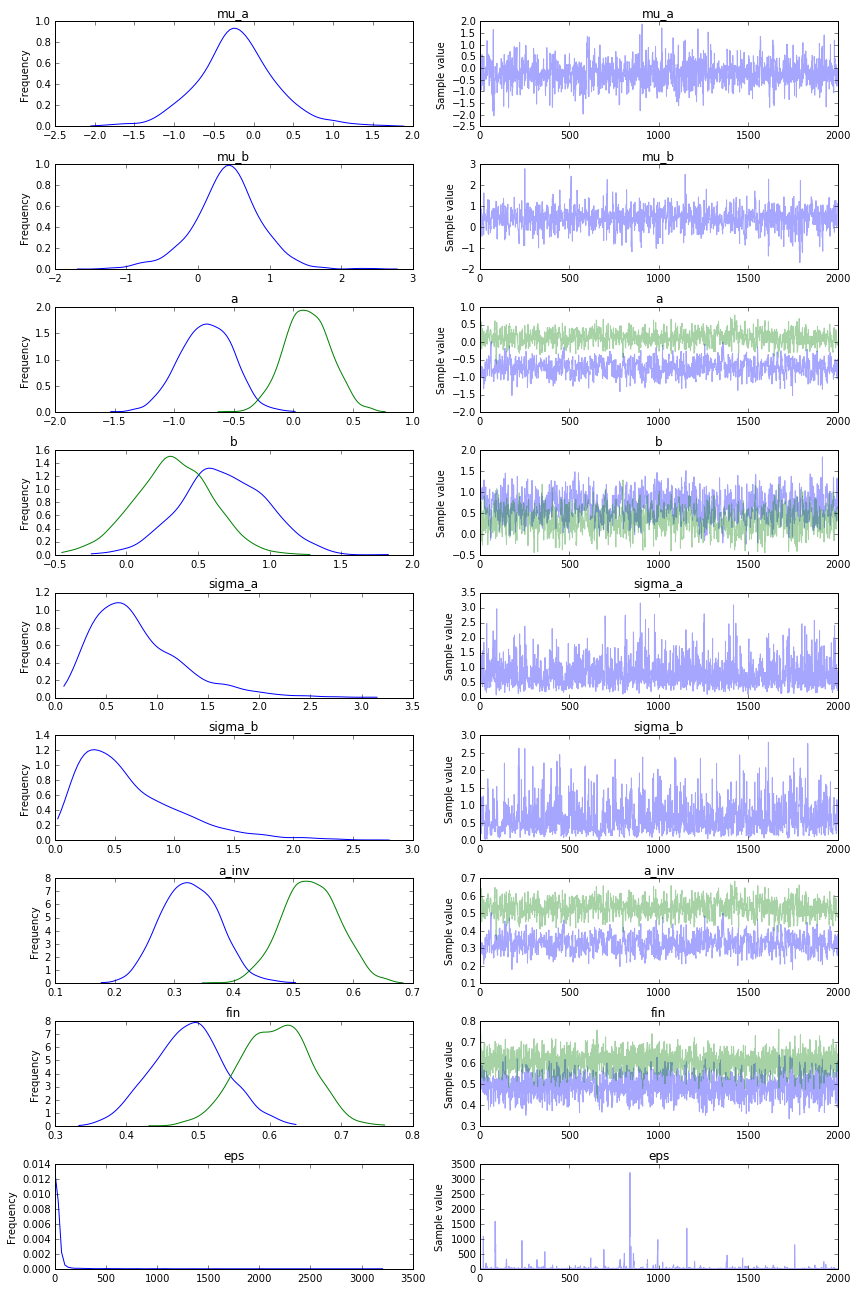

In [21]:
pm.traceplot(mm_trace)

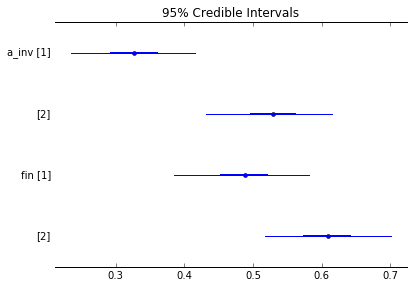

In [22]:
pm.forestplot(mm_trace, varnames=['a_inv', 'fin'])

In [23]:
# probability treatment better than success for Canada

np.mean(mm_trace.get_values('a_inv')[:, 0] < mm_trace.get_values('fin')[:, 0])

0.98850000000000005

In [24]:
# probability treatment better than success for China

np.mean(mm_trace.get_values('a_inv')[:, 1] < mm_trace.get_values('fin')[:, 1])

0.88149999999999995

<br/>

## PyMC2 Beta-Binomial
***

In [25]:
@pymc.stochastic(dtype=np.float64)
def hyperpriors(value=[1.0, 1.0]):
    a, b = value
    if a <= 0 or b <= 0:
        return -np.inf
    else:
        return np.log(np.power((a + b), -2.5))

a = hyperpriors[0]
b = hyperpriors[1]

rates = pymc.Beta('rates', a, b, size=4)

trials = np.array([n] * 4)
successes = np.array(ss)
obs = pymc.Binomial('observed_values', trials, rates, observed=True, value=successes)

mcmc3 = pymc.MCMC([a, b, rates, obs, hyperpriors, trials, successes])

mcmc3.sample(100000, 20000)

 [-----------------100%-----------------] 100000 of 100000 complete in 13.3 sec

In [26]:
rates.summary()


rates:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.324            0.048            0.001            [ 0.23   0.418]
	0.499            0.048            0.001            [ 0.407  0.592]
	0.542            0.048            0.001            [ 0.447  0.633]
	0.587            0.05             0.002            [ 0.49   0.685]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.233            0.29            0.323          0.355         0.421
	0.406            0.467           0.5            0.532         0.592
	0.447            0.509           0.543          0.576         0.634
	0.487            0.553           0.588          0.621         0.683
	


<br/>

## PyMC3 Beta-Binomial
***

In [52]:
with pm.Model() as bb_model:

    def ab_likelihood(value):
        a = value[0]
        b = value[1]
        
        return T.switch(T.or_(T.le(a, 0), T.le(b, 0)),
                        -np.inf,
                        np.log(np.power((a + b), -2.5)))

    ab = pm.DensityDist('ab', ab_likelihood, shape=2, testval=[1.0, 1.0])

    a = ab[0]
    b = ab[1]
                    
    rates = pm.Beta('rates', a, b, shape=4)

    trials = np.array([n] * 4)
    successes = np.array(ss)
    
    obs = pm.Binomial('observed_values', trials, rates, observed=successes)

Applied logodds-transform to rates and added transformed rates_logodds_ to model.


In [53]:
with bb_model:
    bb_trace = pm.sample(2000)

Assigned NUTS to ab
Assigned NUTS to rates_logodds_
 [-----------------100%-----------------] 2000 of 2000 complete in 2.7 sec

In [54]:
pm.summary(bb_trace, varnames=['rates'])


rates:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.322            0.048            0.002            [0.230, 0.415]
  0.498            0.046            0.001            [0.403, 0.588]
  0.542            0.049            0.001            [0.448, 0.635]
  0.587            0.047            0.001            [0.494, 0.680]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.232          0.288          0.320          0.353          0.419
  0.408          0.467          0.499          0.529          0.594
  0.444          0.509          0.542          0.575          0.634
  0.495          0.555          0.587          0.620          0.683

